In [2]:
!pip install tensorflow tensorflow-gpu

  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached requests-2.26.0-py2.py3-none-any.whl (62 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached rsa-4.7.2-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.1-py2.py3-none-any.whl (146 kB)


In [3]:
!pip install opencv-python matplotlib

# IMPORTING DEPENDENCIES

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

# Importing tensorflow dependencies - functional API

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, MaxPooling2D, Flatten
import tensorflow as tf

# Setting GPU growth i.e GPU memory consumption to avoid OutOfMemory Error

In [153]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Paths setups

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# Collecting negative images

In [7]:
# uncompress the Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [4]:
# move lfw images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# Collecting positive and anchor images

In [5]:
import uuid # to get unique name for images

In [7]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    # collecting anchor images by pressing a button
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    # collecting positive images by pressing p button
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    cv2.imshow("Collecting Images", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

In [8]:
frame.shape

(250, 250, 3)

In [9]:
frame[:250, :250, :].shape

(250, 250, 3)

# Load and preprocess the images

In [10]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data\\anchor\\453baa77-493e-11ec-85c2-b4a9fc21e12e.jpg'

In [13]:
# Preprocessing - Scale and resize
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) # reading image from file path
    img = tf.io.decode_jpeg(byte_img)     # load in the image
    img = tf.image.resize(img, (100, 100))# resizing the image to 100X100X3
    img = img/255.0                       # scaling image to be between 0 to 1
    return img

In [14]:
preprocess('data\\anchor\\73f9bfe1-493f-11ec-8938-b4a9fc21e12e.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.66838235, 0.6644608 , 0.71936274],
        [0.67769605, 0.67769605, 0.7247549 ],
        [0.6784314 , 0.672549  , 0.71666664],
        ...,
        [0.7862745 , 0.7745098 , 0.8901961 ],
        [0.79240197, 0.7894608 , 0.9022059 ],
        [0.7892157 , 0.7970588 , 0.89509803]],

       [[0.6627451 , 0.6578431 , 0.7117647 ],
        [0.6666667 , 0.6632353 , 0.71004903],
        [0.6727941 , 0.66495097, 0.7080882 ],
        ...,
        [0.7875    , 0.78088236, 0.88504905],
        [0.7794118 , 0.7794118 , 0.8872549 ],
        [0.7735294 , 0.7794118 , 0.87058824]],

       [[0.68039215, 0.672549  , 0.7235294 ],
        [0.6735294 , 0.66568625, 0.7147059 ],
        [0.6745098 , 0.6666667 , 0.70980394],
        ...,
        [0.7767157 , 0.77892154, 0.86691177],
        [0.78063726, 0.78063726, 0.87671566],
        [0.7889706 , 0.7897059 , 0.88161767]],

       ...,

       [[0.25073528, 0.24681373, 0.27818626],
        [0.23

In [15]:
img1 = preprocess('data\\anchor\\73f9bfe1-493f-11ec-8938-b4a9fc21e12e.jpg')

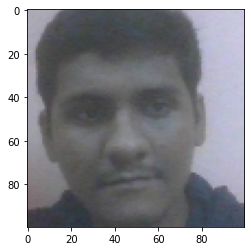

In [16]:
plt.imshow(img1)

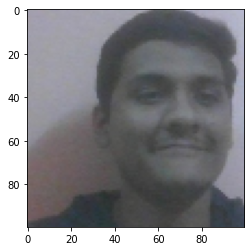

In [17]:
img2 = preprocess('data\\anchor\\4ce8a565-493e-11ec-800f-b4a9fc21e12e.jpg')
plt.imshow(img2)

# Creating labelled dataset

In [102]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [20]:
samples = data.as_numpy_iterator()

In [21]:
eg1 = samples.next()

In [22]:
eg1

(b'data\\anchor\\4c6769bf-493e-11ec-ab72-b4a9fc21e12e.jpg',
 b'data\\positive\\36e83c3d-4940-11ec-8aa5-b4a9fc21e12e.jpg',
 1.0)

In [23]:
print(*eg1)

b'data\\anchor\\4c6769bf-493e-11ec-ab72-b4a9fc21e12e.jpg' b'data\\positive\\36e83c3d-4940-11ec-8aa5-b4a9fc21e12e.jpg' 1.0


# Building Train and Test partition

In [24]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [25]:
preprocess_twin(*eg1)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.6375    , 0.6257353 , 0.66887254],
         [0.6340686 , 0.6193628 , 0.65563726],
         [0.6392157 , 0.6156863 , 0.654902  ],
         ...,
         [0.7203431 , 0.7125    , 0.8007353 ],
         [0.7269608 , 0.7240196 , 0.8269608 ],
         [0.7264706 , 0.7264706 , 0.82843137]],
 
        [[0.63529414, 0.62058824, 0.6647059 ],
         [0.6387255 , 0.6218137 , 0.6666667 ],
         [0.6453431 , 0.6218137 , 0.6644608 ],
         ...,
         [0.7056373 , 0.7019608 , 0.7914216 ],
         [0.71568626, 0.71568626, 0.8235294 ],
         [0.7205882 , 0.722549  , 0.8235294 ]],
 
        [[0.64215684, 0.6186274 , 0.67156863],
         [0.64485294, 0.6213235 , 0.66838235],
         [0.64705884, 0.62352943, 0.67058825],
         ...,
         [0.69730395, 0.7002451 , 0.7875    ],
         [0.7014706 , 0.7058824 , 0.80710787],
         [0.7002451 , 0.7080882 , 0.8061274 ]],
 
        ...,
 
        [[0.3509804 , 0.32328433

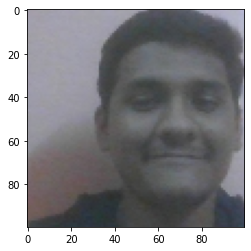

In [26]:
plt.imshow(preprocess_twin(*eg1)[0])

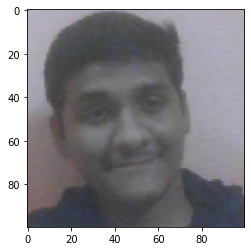

In [27]:
plt.imshow(preprocess_twin(*eg1)[1])

In [28]:
# Building dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [30]:
sample = data.as_numpy_iterator()

In [31]:
res = sample.next()

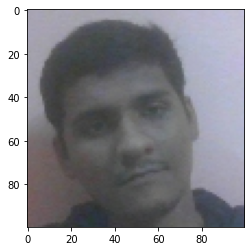

In [32]:
plt.imshow(res[0])

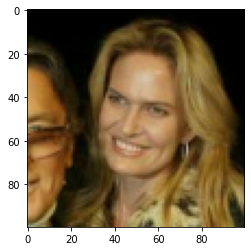

In [33]:
plt.imshow(res[1])

In [34]:
res[2]

0.0

In [35]:
# Training partition
train_data = data.take(round(len(data)*.7))  # i.e taking 70% of data for training data 
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [36]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [37]:
t_sam = train_data.as_numpy_iterator()

In [38]:
tr_sam = t_sam.next()

In [40]:
tr_sam[0]

array([[[[0.6625    , 0.6389706 , 0.6781863 ],
         [0.65294117, 0.63235295, 0.672549  ],
         [0.65833336, 0.64362746, 0.69558823],
         ...,
         [0.7588235 , 0.74313724, 0.8392157 ],
         [0.77181375, 0.7561275 , 0.84632355],
         [0.7656863 , 0.75392157, 0.8362745 ]],

        [[0.6485294 , 0.6357843 , 0.6818628 ],
         [0.65882355, 0.6463235 , 0.69166666],
         [0.65637255, 0.64460784, 0.6862745 ],
         ...,
         [0.75784314, 0.74215686, 0.8367647 ],
         [0.7637255 , 0.7480392 , 0.8382353 ],
         [0.7627451 , 0.7519608 , 0.83431375]],

        [[0.65710783, 0.64730394, 0.7022059 ],
         [0.65416664, 0.64460784, 0.69436276],
         [0.65612745, 0.6458333 , 0.68039215],
         ...,
         [0.7656863 , 0.75      , 0.8401961 ],
         [0.7588235 , 0.747549  , 0.8333333 ],
         [0.7627451 , 0.75490195, 0.8372549 ]],

        ...,

        [[0.44681373, 0.36642158, 0.38504902],
         [0.43308824, 0.3615196 , 0.3762255 ]

In [42]:
len(tr_sam[0])

16

In [43]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [44]:
round(len(data)*.7)

420

In [45]:
round(len(data)*.3)

180

# Model Engineering

In [46]:
inp = Input(shape=(100,100,3), name='input_image')
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [48]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [49]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [50]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [51]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [52]:
# Building Embedding layer
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
model = make_embedding()

In [54]:
model.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [55]:
# Building distance layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [56]:
l1 = L1Dist()

In [57]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [58]:
inp_embedding = model(input_image)

In [59]:
val_embedding = model(validation_image)

In [60]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [61]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [62]:
# Making Siamese Model
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(model(input_image), model(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [63]:
siamese_model = make_siamese_model()

In [64]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

In [65]:
# setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [66]:
opt = tf.keras.optimizers.Adam(1e-4)

In [67]:
# Establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [68]:
# Building train step function
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [69]:
# Building training loop
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(train_data))
        
        for idx, batch in enumerate(train_data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train the model

In [68]:
EPOCHS = 50

In [69]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 66s 2s/step

 Epoch 2/50
27/27 [==============================] - 67s 3s/step

 Epoch 3/50
27/27 [==============================] - 78s 3s/step

 Epoch 4/50
27/27 [==============================] - 81s 3s/step

 Epoch 5/50
27/27 [==============================] - 161s 6s/step

 Epoch 6/50
27/27 [==============================] - 106s 4s/step

 Epoch 7/50
27/27 [==============================] - 107s 4s/step

 Epoch 8/50
27/27 [==============================] - 182s 7s/step

 Epoch 9/50
27/27 [==============================] - 116s 4s/step

 Epoch 10/50
27/27 [==============================] - 111s 4s/step

 Epoch 11/50
27/27 [==============================] - 168s 6s/step

 Epoch 12/50
27/27 [==============================] - 129s 5s/step

 Epoch 13/50
27/27 [======================

# Evaluate model

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [87]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [88]:
test_var = test_data.as_numpy_iterator().next()

In [89]:
test_var

(array([[[[0.6306372 , 0.6306372 , 0.6732843 ],
          [0.62941176, 0.627451  , 0.66764706],
          [0.6269608 , 0.6220588 , 0.65637255],
          ...,
          [0.7264706 , 0.7107843 , 0.8102941 ],
          [0.7254902 , 0.70980394, 0.8004902 ],
          [0.7411765 , 0.7294118 , 0.8117647 ]],
 
         [[0.63161767, 0.6247549 , 0.66495097],
          [0.6137255 , 0.6098039 , 0.64117646],
          [0.6284314 , 0.6245098 , 0.65588236],
          ...,
          [0.7348039 , 0.72769606, 0.8098039 ],
          [0.73333335, 0.73137254, 0.80196077],
          [0.73333335, 0.7323529 , 0.8       ]],
 
         [[0.6333333 , 0.62941176, 0.6607843 ],
          [0.6313726 , 0.627451  , 0.65882355],
          [0.62328434, 0.61715686, 0.6551471 ],
          ...,
          [0.73088235, 0.7267157 , 0.7995098 ],
          [0.7286765 , 0.73406863, 0.79583335],
          [0.71862745, 0.7264706 , 0.7852941 ]],
 
         ...,
 
         [[0.37916666, 0.33137256, 0.3392157 ],
          [0.35906

In [90]:
len(test_var)

3

In [91]:
test_var[0]

array([[[[0.6306372 , 0.6306372 , 0.6732843 ],
         [0.62941176, 0.627451  , 0.66764706],
         [0.6269608 , 0.6220588 , 0.65637255],
         ...,
         [0.7264706 , 0.7107843 , 0.8102941 ],
         [0.7254902 , 0.70980394, 0.8004902 ],
         [0.7411765 , 0.7294118 , 0.8117647 ]],

        [[0.63161767, 0.6247549 , 0.66495097],
         [0.6137255 , 0.6098039 , 0.64117646],
         [0.6284314 , 0.6245098 , 0.65588236],
         ...,
         [0.7348039 , 0.72769606, 0.8098039 ],
         [0.73333335, 0.73137254, 0.80196077],
         [0.73333335, 0.7323529 , 0.8       ]],

        [[0.6333333 , 0.62941176, 0.6607843 ],
         [0.6313726 , 0.627451  , 0.65882355],
         [0.62328434, 0.61715686, 0.6551471 ],
         ...,
         [0.73088235, 0.7267157 , 0.7995098 ],
         [0.7286765 , 0.73406863, 0.79583335],
         [0.71862745, 0.7264706 , 0.7852941 ]],

        ...,

        [[0.37916666, 0.33137256, 0.3392157 ],
         [0.35906863, 0.3137255 , 0.32132354]

In [92]:
len(test_var[0])

16

In [93]:
test_var[1]

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.22426471, 0.34509805, 0.18455882],
         [0.3137255 , 0.4627451 , 0.29313725]

In [94]:
len(test_var[1])

16

In [95]:
test_var[2]

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

In [96]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

In [97]:
y_hat

array([[0.5012511 ],
       [0.50013596],
       [0.5003799 ],
       [0.501007  ],
       [0.501335  ],
       [0.49998522],
       [0.49983084],
       [0.5001429 ],
       [0.5006896 ],
       [0.5009728 ],
       [0.50053394],
       [0.5004828 ],
       [0.50063455],
       [0.50022477],
       [0.5001285 ],
       [0.5000373 ]], dtype=float32)

In [98]:
# Post processing the result
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [99]:
y_true  # test_var[2]

array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [100]:
m = Recall()                  # creating a metric object
m.update_state(y_true, y_hat) # calculating the recall value
m.result().numpy()            

0.5

In [101]:
m = Precision()                  # creating a metric object
m.update_state(y_true, y_hat) # calculating the recall value
m.result().numpy()  

0.14285715

# visualizing results

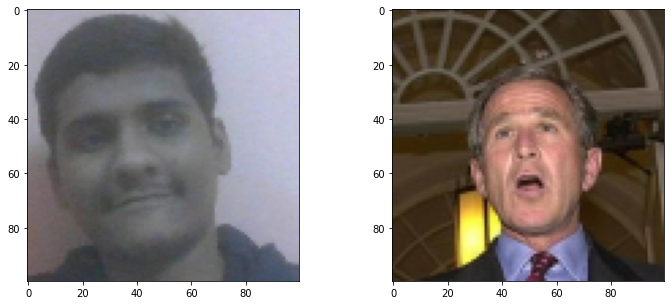

In [102]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

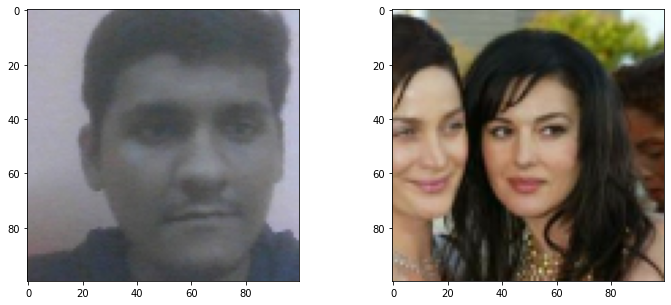

In [103]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1) # subplot(no_row, no_col, index)
plt.imshow(test_input[1])
plt.subplot(1,2,2)
plt.imshow(test_val[1])
plt.show()

In [104]:
# so from above(y_true or prediction) we can see that again at 5th and 8th position we got an negative i.e 0 and rest all postion positive i.e 1

# Save model

In [114]:
# save weights
siamese_model.save('siamesemodel.h5')

In [105]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [106]:
model.predict([test_input, test_val])

array([[7.6922771e-07],
       [4.0655358e-08],
       [9.5391279e-01],
       [3.8344037e-06],
       [6.9254511e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.7351828e-08],
       [1.6299283e-06],
       [2.6455737e-07],
       [8.1965844e-08],
       [2.1777607e-08],
       [4.6006525e-07],
       [1.0770462e-06],
       [9.9999452e-01],
       [3.1565446e-07]], dtype=float32)

In [107]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Real time test

In [108]:
# Verification function
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    # Detection threshold : Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    # Verification threshold : Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

In [133]:
# OpenCV Real time verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # saving input image to input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # running verification function
        results, verified = verify(model, 0.9, 0.8)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
True
True
True
False
False


In [126]:
results

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.97446966]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[0.90866786]], dtype=float32),
 array([[0.9765069]], dtype=float32),
 array([[0.99943036]], dtype=float32),
 array([[0.9991948]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99736905]], dtype=float32),
 array([[0.9991054]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999993]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9994777]], dtype=float32),
 array([[0.81567687]], dtype=float32),
 array([[0.7886792]], dtype=float32),
 array([[0.5622191]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 arr

In [127]:
np.squeeze(results) > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [128]:
np.sum(np.squeeze(results) > 0.5)

50

In [129]:
np.sum(np.squeeze(results) > 0.6)

49

In [130]:
np.sum(np.squeeze(results) > 0.7)

49

In [131]:
np.sum(np.squeeze(results) > 0.8)

48

In [132]:
np.sum(np.squeeze(results) > 0.9)

45